In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils.imports import *
from dataloader import *

/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
!ls ../data/SRAD2018/

SRAD2018_Test_1     SRAD2018_TRAIN_003	SRAD2018_TRAIN_006  SRAD2018_TRAIN_009
SRAD2018_TRAIN_001  SRAD2018_TRAIN_004	SRAD2018_TRAIN_007  zip
SRAD2018_TRAIN_002  SRAD2018_TRAIN_005	SRAD2018_TRAIN_008


In [3]:
!ls ../data/SRAD2018/SRAD2018_TRAIN_001/RAD_206482464212530/RAD_206482464212530_000.png

SRAD2018_Test_1     SRAD2018_TRAIN_003	SRAD2018_TRAIN_006  SRAD2018_TRAIN_009
SRAD2018_TRAIN_001  SRAD2018_TRAIN_004	SRAD2018_TRAIN_007  zip
SRAD2018_TRAIN_002  SRAD2018_TRAIN_005	SRAD2018_TRAIN_008


Probably merge datasets or map them into logical one

Use CSV file?

In [3]:
PATH = Path('../data')
num_datasets = 1

dataset_idx = range(1, num_datasets + 1)

In [6]:
tfms = lambda *args: args

In [12]:
??data.Dataset

Init signature: data.Dataset()
Source:        
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
File:           ~/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataset.py
Type:           type


In [4]:
fn_datasets = fn_idx_to_dir_names(dataset_idx, True)

In [7]:
train_dataset = [SRAD2018(PATH/'SRAD2018'/o, True, PredMode.Skip1, k=12, transform=None)
                 for o in fn_datasets]

In [8]:
t = train_dataset[0]

In [98]:
t.sequence_index

[[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
 [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56],
 [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57],
 [3, 8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58],
 [4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59]]

In [12]:
t[0][0].shape

(501, 501, 1)

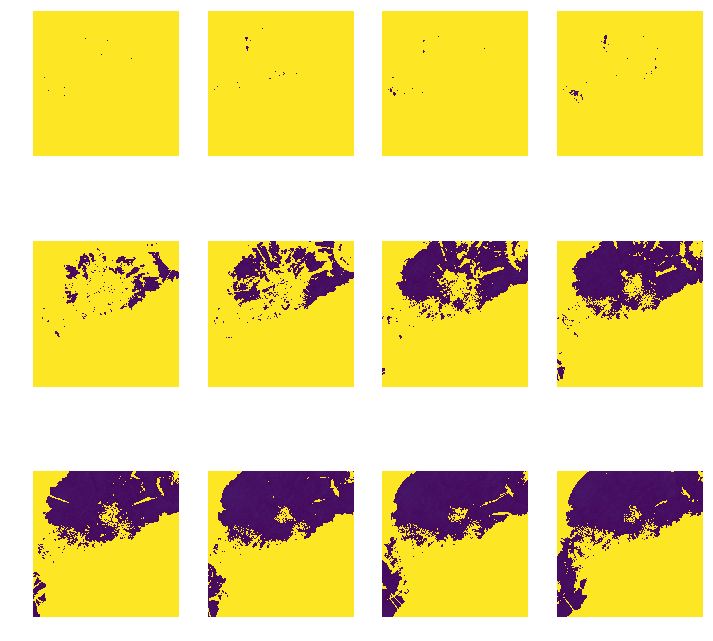

In [26]:
plots(im, (12,12), 3)

In [30]:
im_fixed = np.copy(im)
im_fixed *= (im != 255.)
# im_fixed *= np.abs(im - 255) < 0.1

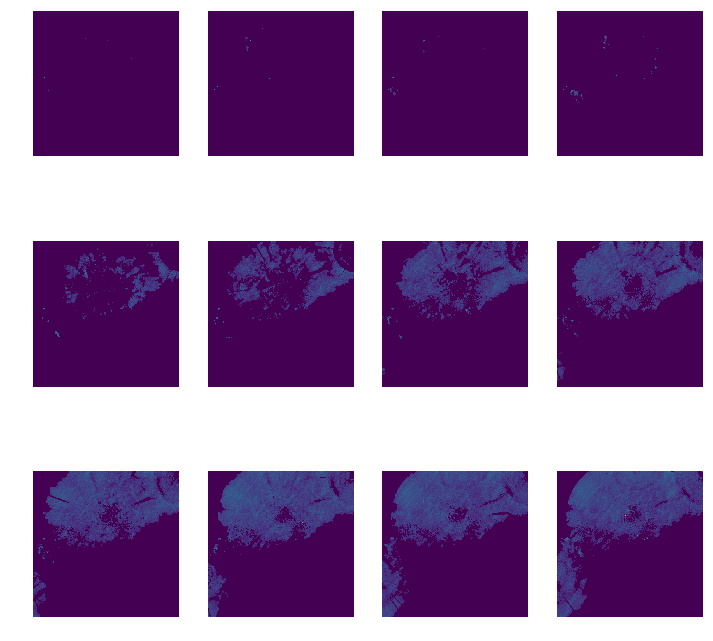

In [36]:
plots(im_fixed, (12,12), 3, vmin=0, vmax=np.max(im_fixed))

In [45]:
mean, std = 0.22, 0.90
normalize = transforms.Normalize(mean, std)

In [48]:
class args:
    pass

In [57]:
args.bs = 5
args.workers = 8
args.world_size = 2
args.distributed = args.world_size > 1
args.trn_val_split = 0.8
pred_mode = PredMode.Skip1
args.k = 12
args.prof = True

In [63]:
from fastai.transforms import RandomLighting
from torch.utils.data.distributed import DistributedSampler

def torch_loader(data_path, dataset_idx, size, trn_val_split=0.8):
    # TODO: average more stats
    # TODO: return test set
    mean, std = 0.22, 0.90
    normalize = transforms.Normalize(mean, std)
    resize = transforms.Resize(size)
    tfms = [resize, transforms.ToTensor(), normalize]
    
    random_lighting = RandomLighting(0.05, 0.05)
    
    fn_trn_datasets = [data_path/o for o in fn_idx_to_dir_names(dataset_idx, True)]
#     fn_val_datasets = fn_idx_to_dir_names(dataset_idx, False)
    
    # TODO: add batch transforms
    # TODO: check if the transforms applys to data of four dimension data
    trn_tfms = transforms.Compose([random_lighting] + [tfms])
    trn_dataset = sum([SRAD2018(o, True, pred_mode, args.k, trn_tfms, args.trn_val_split)
                   for o in fn_trn_datasets])
    trn_sampler = (DistributedSampler(trn_dataset, args.world_size)
                    if args.world_size else None)
    train_loader = data.Dataloader(
        train_dataset, batch_size = args.bs, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_tfms = transforms.Compose(tfms)
    val_dataset = sum([SRAD2018(o, False, pred_mode, args.k, val_tfms, args.trn_val_split)
                   for o in fn_trn_datasets])
    val_loader = data.DataLoader(
        val_dataset, args.bs, False, num_workers=args.workers, pin_memory=True)
    
    trn_loader = DataPrefetcher(trn_loader)
    val_loader = DataPrefetcher(val_loader)
    
    if args.prof:
        trn_loader.stop_after = 200
        val_loader.stop_after = 0
        
    data = TorchModelData(data_path, args.sz, trn_loader, val_loader)
    return data, trn_sampler

In [62]:
# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [61]:
from fastai.dataset import ModelData
class TorchModelData(ModelData):
    def __init__(self, path, sz, trn_dl, val_dl, aug_dl=None):
        super().__init__(path, trn_dl, val_dl)
        self.aug_dl = aug_dl
        self.sz = sz

## Test torch_loader

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from dataloader import *

/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
class args:
    pass

args.bs = 5
args.sz = 256
args.workers = 1
args.world_size = 1
args.distributed = args.world_size > 1
args.trn_val_split = 0.8
args.pred_mode = 1
pred_mode = PredMode(args.pred_mode)
args.k = 12
args.prof = True
args.dist_backend = 'nccl'
args.dist_url = 'file://sync.file'

In [4]:
import torch.distributed as dist
dist.init_process_group(backend=args.dist_backend, world_size=args.world_size)

RuntimeError: _Map_base::at

In [4]:
size = 256
dataset_idx = 1
data_path = '../data/SRAD2018/'
data_path = Path(data_path)


mean, std = 0.22, 0.90
normalize = transforms.Normalize(mean, std)
# resize = transforms.Resize(size)
# tfms = [resize, transforms.ToTensor(), normalize]
tfms = [transforms.ToTensor(), normalize]

random_lighting = RandomLighting(0.05, 0.05)

fn_trn_datasets = [data_path/o for o in fn_idx_to_dir_names(dataset_idx, True)]
#     fn_val_datasets = fn_idx_to_dir_names(dataset_idx, False)

# TODO: add batch transforms
# TODO: check if the transforms applys to data of four dimension data
trn_tfms = transforms.Compose([random_lighting] + [tfms])
trn_dataset = reduce(sum, [SRAD2018(o, True, pred_mode, args.k, trn_tfms, args.trn_val_split)
               for o in fn_trn_datasets])
trn_sampler = (DistributedSampler(trn_dataset, args.world_size)
                if args.distributed else None)
trn_loader = data.DataLoader(
    trn_dataset, batch_size = args.bs, shuffle=(trn_sampler is None),
    num_workers=args.workers, pin_memory=True, sampler=trn_sampler)

val_tfms = transforms.Compose(tfms)
val_dataset = reduce(sum, [SRAD2018(o, False, pred_mode, args.k, val_tfms, args.trn_val_split)
               for o in fn_trn_datasets])
val_loader = data.DataLoader(
    val_dataset, args.bs, False, num_workers=args.workers, pin_memory=True)

trn_loader = DataPrefetcher(trn_loader)
val_loader = DataPrefetcher(val_loader)

if args.prof:
    trn_loader.stop_after = 200
    val_loader.stop_after = 0

md = TorchModelData(data_path, args.sz, trn_loader, val_loader)
# return data, trn_sampler

In [5]:
t = next(iter(md.trn_dl))

In [6]:
t[0].shape

torch.Size([5, 12, 501, 501, 1])

In [5]:
it = iter(trn_loader)

In [6]:
print('hi')

hi


In [7]:
t = next(it)

In [8]:
len(t)

5

In [11]:
t.shape

torch.Size([5, 12, 501, 501, 1])

In [9]:
len(t[0])

12

In [10]:
t[0].shape

torch.Size([12, 501, 501, 1])

### Putting it all together

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
from dataloader import *

/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
md, trn_sampler = torch_loader('../data/SRAD2018/', 1, 1, 256, debug=True)

In [3]:
md_iter = iter(md.trn_dl)
t = next(md_iter)[0].cpu()

In [4]:
t.shape

torch.Size([5, 12, 256, 256])